In [1]:
%load_ext autoreload
%autoreload 2

from abc import ABC, abstractmethod
from functools import partial
from typing import Literal

import einops as ei
import jaxtyping as jty
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from beartype import beartype
from IPython.display import display
from sklearn import metrics

from src.utils.misc import dataclass, tqdm

typed = partial(jty.jaxtyped, typechecker=beartype)

In [2]:
prop99_df = pl.read_csv('data/california_prop_99.txt', separator='\t')
prop99_df = prop99_df.rename(
    mapping={
        '1': 'Alabama',
        '2': 'Arkansas',
        '3': 'California',
        '4': 'Colorado',
        '5': 'Connecticut',
        '6': 'Delaware',
        '7': 'Georgia',
        '8': 'Idaho',
        '9': 'Illinois',
        '10': 'Indiana',
        '11': 'Iowa',
        '12': 'Kansas',
        '13': 'Kentucky',
        '14': 'Louisiana',
        '15': 'Maine',
        '16': 'Minnesota',
        '17': 'Mississippi',
        '18': 'Missouri',
        '19': 'Montana',
        '20': 'Nebraska',
        '21': 'Nevada',
        '22': 'New Hampshire',
        '23': 'New Mexico',
        '24': 'North Carolina',
        '25': 'North Dakota',
        '26': 'Ohio',
        '27': 'Oklahoma',
        '28': 'Pennsylvania',
        '29': 'Rhode Island',
        '30': 'South Carolina',
        '31': 'South Dakota',
        '32': 'Tennessee',
        '33': 'Texas',
        '34': 'Utah',
        '35': 'Vermont',
        '36': 'Virginia',
        '37': 'West Virginia',
        '38': 'Wisconsin',
        '39': 'Wyoming',
    },
)
prop99_df = prop99_df.drop('California')  # [7:]

prop99_df = prop99_df.with_row_index(name='year', offset=1970)
prop99_df = prop99_df.cast(dtypes={'year': str})
prop99_df = prop99_df.transpose(include_header=True, header_name='state', column_names='year')
display(prop99_df)

prop99_data = prop99_df[:, 1:].to_numpy()
display(prop99_data)

state,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Alabama""",9.678974,89.344445,0.174802,18.96,112.099998,123.199997,111.699997,89.800003,95.400002,101.099998,102.900002,108.199997,111.699997,116.199997,117.099998,123.0,121.400002,123.199997,119.599998,119.099998,116.300003,113.0,114.5,116.300003,114.0,112.099998,105.599998,108.599998,107.900002,109.099998,108.5,107.099998,102.599998,101.400002,104.900002,106.199997,100.699997,96.199997
"""Arkansas""",9.643623,89.877777,0.164611,18.52,121.5,131.800003,114.800003,100.300003,104.099998,103.900002,108.0,109.699997,114.800003,119.099998,122.599998,127.300003,126.5,131.800003,128.699997,127.400002,128.0,123.099998,125.800003,126.0,122.300003,121.5,118.300003,113.099998,116.800003,126.0,113.800003,108.800003,113.0,110.699997,108.699997,109.5,104.800003,99.400002
"""Colorado""",9.984357,82.622222,0.173703,25.08,94.599998,131.0,131.0,124.800003,125.5,134.300003,137.899994,132.800003,131.0,134.199997,132.0,129.199997,131.5,131.0,133.800003,130.5,125.300003,119.699997,112.400002,109.900002,102.400002,94.599998,88.800003,87.400002,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.0
"""Connecticut""",10.188035,103.477776,0.16366,20.7,104.800003,118.0,110.199997,120.0,117.599998,110.800003,109.300003,112.400002,110.199997,113.400002,117.300003,117.5,117.400002,118.0,116.400002,114.699997,114.099998,112.5,111.0,108.5,109.0,104.800003,100.599998,91.5,86.699997,83.5,79.099998,76.599998,79.300003,76.0,75.900002,75.5,73.400002,71.400002
"""Delaware""",9.974561,90.055555,0.178224,26.08,137.100006,150.5,147.600006,155.0,161.100006,156.300003,154.699997,151.300003,147.600006,153.0,153.300003,155.5,150.199997,150.5,152.600006,154.100006,149.600006,144.0,144.5,142.399994,141.0,137.100006,131.699997,127.199997,118.800003,120.0,123.800003,126.099998,127.199997,128.300003,124.099998,132.800003,139.5,140.699997
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Vermont""",9.821149,88.022223,0.177342,27.06,128.699997,161.600006,155.5,122.599998,124.400002,138.0,146.800003,151.800003,155.5,171.100006,169.399994,162.399994,160.899994,161.600006,163.800003,162.300003,153.800003,144.300003,144.5,131.199997,128.300003,128.699997,120.900002,124.300003,120.900002,126.5,117.199997,120.300003,123.199997,102.5,97.699997,97.0,94.099998,88.900002
"""Virginia""",9.957433,74.788889,0.177403,23.0,129.5,148.899994,152.699997,124.300003,128.399994,137.0,143.100006,149.600006,152.699997,158.100006,157.699997,155.899994,151.800003,148.899994,149.899994,147.399994,144.699997,136.800003,134.600006,135.800003,133.0,129.5,122.5,118.900002,109.099998,108.199997,105.400002,106.199997,106.699997,104.599998,108.0,105.599998,102.099998,96.699997
"""West Virginia""",9.654764,92.588888,0.164831,19.8,109.099998,122.300003,123.199997,114.5,111.5,117.5,116.599998,119.900002,123.199997,129.699997,133.899994,131.600006,122.099998,122.300003,120.5,119.800003,115.699997,111.900002,109.099998,112.099998,107.5,109.099998,104.0,104.099998,100.099998,97.900002,111.0,104.199997,115.199997,112.699997,114.5,114.599998,112.400002,107.900002


array([[  9.67897362,  89.34444512,   0.1748019 , ..., 106.1999969 ,
        100.6999969 ,  96.19999695],
       [  9.64362325,  89.8777771 ,   0.16461137, ..., 109.5       ,
        104.8000031 ,  99.40000153],
       [  9.9843572 ,  82.62222205,   0.17370325, ...,  81.19999695,
         79.59999847,  73.        ],
       ...,
       [  9.65476354,  92.58888753,   0.16483051, ..., 114.5999985 ,
        112.4000015 , 107.9000015 ],
       [  9.88299359,  95.15555784,   0.17454639, ...,  88.69999695,
         84.40000153,  80.09999847],
       [  9.91366111,  81.00000042,   0.17420705, ..., 102.9000015 ,
        104.8000031 ,  90.5       ]], shape=(38, 38))

In [3]:
@typed
def simulate_treatment(
    data: jty.Float[np.ndarray, 'N T'],
    treatment_time_idx: int,
    num_treated_units: int,
    treatment_type: Literal['simultaneous', 'staggered'],
    seed: int = 0,
) -> jty.Float[np.ma.masked_array, 'N T']:
    dim_N, dim_T = data.shape
    rng = np.random.default_rng(seed=seed)
    treated_unit_idxs = rng.choice(np.arange(dim_N), size=num_treated_units, replace=False)
    treatment_mask = np.zeros_like(data, dtype=int)

    match treatment_type:
        case 'simultaneous':
            treatment_mask[treated_unit_idxs, treatment_time_idx:] = 1
        case 'staggered':
            staggered_treatment_time_idxs = rng.choice(
                np.arange(treatment_time_idx, dim_T), size=num_treated_units
            )
            for unit_idx, time_idx in zip(treated_unit_idxs, staggered_treatment_time_idxs):
                treatment_mask[unit_idx, time_idx:] = 1

    return np.ma.masked_array(data, mask=treatment_mask.astype(bool))


fake_data = np.asarray(
    [
        [1, 2, 3, 4, 5, 6],
        [2, 3, 4, 5, 6, 7],
        [3, 4, 5, 6, 7, 8],
        [4, 5, 6, 7, 8, 9],
        [5, 6, 7, 8, 9, 10],
        [6, 7, 8, 9, 10, 11],
        [7, 8, 9, 10, 11, 12.0],
    ],
    dtype=float,
)

data = fake_data
masked_data = simulate_treatment(
    data=data,
    treatment_time_idx=3,
    num_treated_units=2,
    treatment_type='simultaneous',
    seed=0,
)

# data = prop99_data
# masked_data = simulate_treatment(
#     data=data,
#     treatment_time_idx=15,
#     num_treated_units=1,
#     treatment_type='simultaneous',
#     seed=0
# )

masked_data

masked_array(
  data=[[1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
        [2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
        [3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
        [4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
        [5.0, 6.0, 7.0, --, --, --],
        [6.0, 7.0, 8.0, --, --, --],
        [7.0, 8.0, 9.0, 10.0, 11.0, 12.0]],
  mask=[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False, False, False]],
  fill_value=1e+20)

In [4]:
@dataclass
class BaseOutput:
    imputed_data: jty.Float[np.ndarray, 'N T']


@typed
class BaseImputer(ABC):
    @abstractmethod
    def impute(self, data: jty.Float[np.ma.masked_array, 'N T']) -> BaseOutput:
        pass


@typed
def threshold_singular_value(
    inputs: jty.Float[np.ndarray, 'N T'], threshold: float
) -> jty.Float[np.ndarray, 'N T']:
    mat_U, vec_S, mat_Vt = np.linalg.svd(inputs, full_matrices=False)
    vec_S_hat = (vec_S - threshold).clip(min=0.0)
    return mat_U @ np.diag(vec_S_hat) @ mat_Vt


@typed
def transpose(
    inputs: jty.Float[np.ndarray, 'A B'] | jty.Float[np.ndarray, 'A'],
):
    match inputs.shape:
        case (_, _):
            return ei.rearrange(inputs, 'A B -> B A')
        case (_,):
            return ei.rearrange(inputs, 'A -> 1 A')
        case _:
            raise ValueError
    return inputs


class MCNNMOutput(BaseOutput):
    covariates: jty.Float[np.ndarray, 'N T']
    time_fixed_effects: jty.Float[np.ndarray, 'T']
    unit_fixed_effects: jty.Float[np.ndarray, 'N']


@typed
class MCNNM(BaseImputer):
    def __init__(
        self,
        shrinkage_threshold: float,
        num_iters: int,
    ):
        self.shrinkage_threshold = shrinkage_threshold
        self.num_iters = num_iters

    def _compute_tfe(
        self,
        mat_Y_masked: jty.Float[np.ma.masked_array, 'N T'],
        mat_L: jty.Float[np.ndarray, 'N T'],
        vec_gamma: jty.Float[np.ndarray, 'N T'],
    ):
        _, dim_T = mat_Y_masked.shape

        mat_tfe = mat_Y_masked - mat_L - ei.repeat(vec_gamma, 'N -> N T', T=dim_T)
        # np.ma.mask_array automatically ignore missing values
        return ei.reduce(mat_tfe, 'N T -> T', np.mean)

    def _compute_ufe(
        self,
        mat_Y_masked: jty.Float[np.ma.masked_array, 'N T'],
        mat_L: jty.Float[np.ndarray, 'N T'],
        vec_delta: jty.Float[np.ndarray, 'T'],
    ):
        dim_N, _ = mat_Y_masked.shape

        mat_ufe = mat_Y_masked - mat_L - ei.repeat(vec_delta, 'T -> N T', N=dim_N)
        # np.ma.mask_array automatically ignore missing values
        return ei.reduce(mat_ufe, 'N T -> N', np.mean)

    def _compute_Y(
        self,
        mat_L: jty.Float[np.ndarray, 'N T'],
        vec_delta: jty.Float[np.ndarray, 'T'],
        vec_gamma: jty.Float[np.ndarray, 'N'],
    ):
        dim_N, dim_T = mat_L.shape
        return (
            mat_L
            + ei.repeat(vec_delta, 'T -> N T', N=dim_N)
            + ei.repeat(vec_gamma, 'N -> N T', T=dim_T)
        )

    def impute(self, data: jty.Float[np.ma.masked_array, 'N T']) -> jty.Float[np.ndarray, 'N T']:
        dim_N, dim_T = data.shape

        mat_Y_masked = data
        vec_delta = np.zeros(dim_T)
        vec_gamma = np.zeros(dim_N)
        mat_L = np.zeros((dim_N, dim_T))

        for _ in tqdm(range(self.num_iters), desc='Iterative optimization'):
            vec_gamma = self._compute_ufe(mat_Y_masked, mat_L, vec_delta)
            vec_delta = self._compute_tfe(mat_Y_masked, mat_L, vec_gamma)

            mat_Y = self._compute_Y(mat_L, vec_delta, vec_gamma)

            mat_L = threshold_singular_value(
                # fill missing value with 0
                inputs=(mat_Y_masked - mat_Y).filled(0) + mat_L,
                threshold=self.shrinkage_threshold * mat_Y_masked.count() / 2,
            )

        mat_Y = self._compute_Y(mat_L, vec_delta, vec_gamma)

        return MCNNMOutput(
            imputed_data=mat_Y,
            covariates=mat_L,
            time_fixed_effects=vec_delta,
            unit_fixed_effects=vec_gamma,
        )


mcnnm = MCNNM(
    shrinkage_threshold=0.005,
    num_iters=100,
)
mcnnm_output = mcnnm.impute(masked_data)
print(mcnnm_output.imputed_data)
print(metrics.root_mean_squared_error(data, mcnnm_output.imputed_data))

Iterative optimization:   0%|          | 0/100 [00:00<?, ?it/s]

[[1.0 2.0 3.0 4.0 5.0 6.0]
 [2.0 3.0 4.0 5.0 6.0 7.0]
 [3.0 4.0 5.0 6.0 7.0 8.0]
 [4.0 5.0 6.0 7.0 8.0 9.0]
 [5.0 6.0 7.0 8.0 9.0 10.0]
 [6.0 7.0 8.0 9.0 10.0 11.0]
 [7.0 8.0 9.0 10.0 11.0 12.0]]
0.0


In [5]:
@dataclass
class EOpROutput(BaseOutput):
    covariance: jty.Float[np.ndarray, 'T T']
    representation: jty.Float[np.ndarray, 'T T']
    error_bound: jty.Float[np.ndarray, 'N T']


@typed
class EOpR(BaseImputer):
    def __init__(self, reg_coef: float):
        self.reg_coef = reg_coef
        self.state = None

    def _compute_idxs(self, data: jty.Float[np.ma.masked_array, 'N T']):
        mask_counts = np.ma.count_masked(data, axis=1)
        treated_idxs = (mask_counts != 0).nonzero()[0]
        control_idxs = (mask_counts == 0).nonzero()[0]
        return treated_idxs, control_idxs

    def impute(self, data: jty.Float[np.ma.masked_array, 'N T']) -> jty.Float[np.ndarray, 'N T']:
        _, dim_T = data.shape

        treated_idxs, control_idxs = self._compute_idxs(data)

        mat_S = data[control_idxs].filled(0)
        mat_Sigma = transpose(mat_S) @ mat_S + np.identity(dim_T) * self.reg_coef
        mat_Q = np.linalg.pinv(mat_Sigma)

        mat_Phi = mat_Sigma.T @ mat_Q @ mat_Sigma
        # We can similarly have
        # mat_Phi[:t0, :t0] = transpose(mat_Sigma[:, :t0]) @ mat_Q @ mat_Sigma[:, :t0]
        # Therefore, doing this, we only have to compute it once

        all_vec_s = []
        all_vec_delta = []

        # Simplest approach, compute separate synthetic control for each treated unit
        # May have some drawbacks, improve later
        for treated_idx in tqdm(treated_idxs, 'Computing synthetic controls'):
            vec_s_masked = data[treated_idx]
            t0 = vec_s_masked.mask.nonzero()[0][0]
            vec_s_pre = vec_s_masked[:t0].filled(0)

            mat_Phi_inv = np.linalg.inv(mat_Phi[:t0, :t0])
            vec_w = mat_Phi_inv @ vec_s_pre
            vec_s = mat_Sigma[:, :t0] @ vec_w
            all_vec_s.append(vec_s)

            # It is still unclear how to compute the error bound
            # The current error bound implementation is more of a direct translation of original code
            # May still have some error since it was pretty difficult to read
            # ERROR BOUND ====
            mat_C = mat_Phi_inv @ mat_Phi[:t0, :]
            mat_Y = mat_Sigma - mat_Sigma[:, :t0] @ mat_C

            vec_y = np.where(
                np.diag(mat_Y) > 0.001,
                np.diag(mat_Y) / np.sqrt(np.diag(transpose(mat_Y) @ mat_Q @ mat_Y)),
                np.diag(mat_Y),
            )
            vec_delta = np.sqrt(np.abs(1e-5 - transpose(vec_s) @ mat_Q @ vec_s)) * vec_y
            all_vec_delta.append(vec_delta)
            # END ERROR BOUND ===

        imputed_data = data.filled(0)
        imputed_data[treated_idxs] = ei.pack(all_vec_s, '* T')[0]

        error_bound = np.zeros_like(imputed_data)
        error_bound[treated_idxs] = ei.pack(all_vec_delta, '* T')[0]
        return EOpROutput(
            imputed_data=imputed_data,
            covariance=mat_Sigma,
            representation=mat_Phi,
            error_bound=error_bound,
        )


eopr_output = EOpR(reg_coef=1e-4).impute(masked_data)
print(eopr_output.imputed_data)
print(metrics.root_mean_squared_error(data, eopr_output.imputed_data))

Computing synthetic controls:   0%|          | 0/2 [00:00<?, ?it/s]

[[ 1.          2.          3.          4.          5.          6.        ]
 [ 2.          3.          4.          5.          6.          7.        ]
 [ 3.          4.          5.          6.          7.          8.        ]
 [ 4.          5.          6.          7.          8.          9.        ]
 [ 5.          6.          7.          8.00001069  9.0000173  10.0000239 ]
 [ 6.          7.          8.          9.00002987 10.00004685 11.00006384]
 [ 7.          8.          9.         10.         11.         12.        ]]
9.439351897423904e-06


Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating patients:   0%|          | 0/1 [00:00<?, ?it/s]

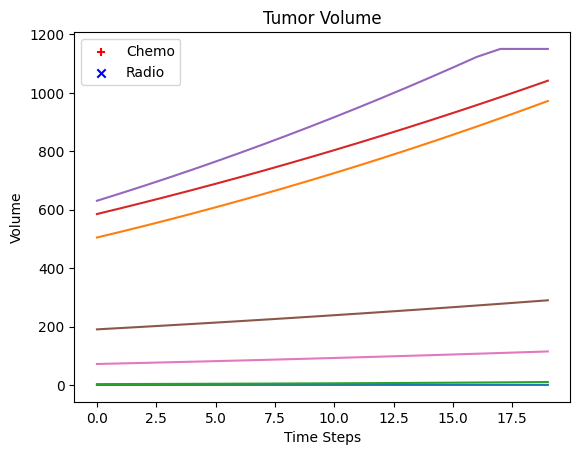

In [6]:
from src.simulations.non_small_lung_cancer import (
    DoNothingPlan,
    plot_results,
    run_simulation,
)

num_time_steps = 20
num_patients = 10
num_treated_units = 10

patient_profiles = []
results = []

for idx, mask in enumerate(masked_data.mask):
    (patient_params,), (result,) = run_simulation(
        num_patients=1,
        num_time_steps=num_time_steps,
        treatment_plan=DoNothingPlan(),
        seed=idx,
    )
    patient_profiles.append(patient_params)
    results.append(result)

cancer_data = ei.pack(
    [np.asarray(result.tumor_model.state.volumes) for result in results],
    '* t',
)[0]
plot_results(results=results)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Iterative optimization:   0%|          | 0/200 [00:00<?, ?it/s]

Computing synthetic controls:   0%|          | 0/5 [00:00<?, ?it/s]

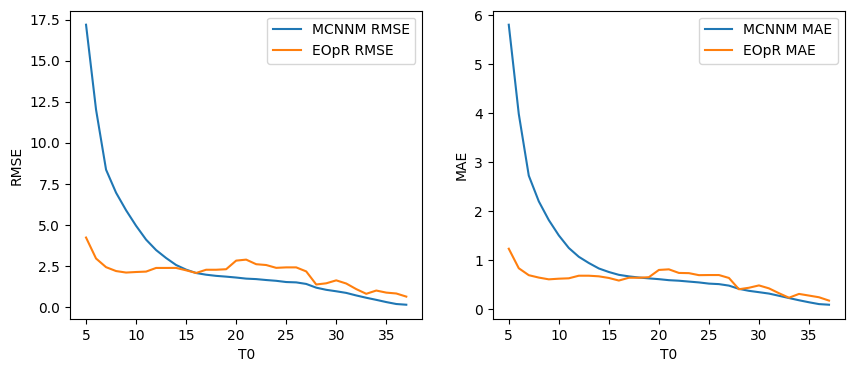

In [9]:
data = prop99_data
# data = cancer_data

_, num_time_steps = data.shape

eopr_rmses = []
mcnnm_rmses = []
eopr_maes = []
mcnnm_maes = []

num_seeds = 4
start_time = 5

for seed in tqdm(range(num_seeds)):
    for i in tqdm(list(range(num_time_steps))[start_time:]):
        masked_data = simulate_treatment(
            data=data,
            treatment_time_idx=i,
            num_treated_units=5,
            treatment_type='simultaneous',
            seed=seed,
        )

        best_rmse = float('inf')
        best_mae = float('inf')
        for threshold in [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]:
            mcnnm_output = MCNNM(shrinkage_threshold=0.001, num_iters=200).impute(masked_data)
            mcnnm_rmse = metrics.root_mean_squared_error(data, mcnnm_output.imputed_data)
            mcnnm_mae = metrics.mean_absolute_error(data, mcnnm_output.imputed_data)

            if mcnnm_rmse < best_rmse:
                best_rmse = mcnnm_rmse
            if mcnnm_mae < best_mae:
                best_mae = mcnnm_mae

        eopr_output = EOpR(reg_coef=1e-5).impute(masked_data)
        eopr_rmse = metrics.root_mean_squared_error(data, eopr_output.imputed_data)
        eopr_mae = metrics.mean_absolute_error(data, eopr_output.imputed_data)

        mcnnm_rmses.append(best_rmse)
        eopr_rmses.append(eopr_rmse)
        mcnnm_maes.append(best_mae)
        eopr_maes.append(eopr_mae)

plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(mcnnm_rmses), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='MCNNM RMSE',
)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(eopr_rmses), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='EOpR RMSE',
)
plt.xlabel('T0')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(mcnnm_maes), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='MCNNM MAE',
)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(eopr_maes), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='EOpR MAE',
)
plt.xlabel('T0')
plt.ylabel('MAE')
plt.legend()

plt.show()

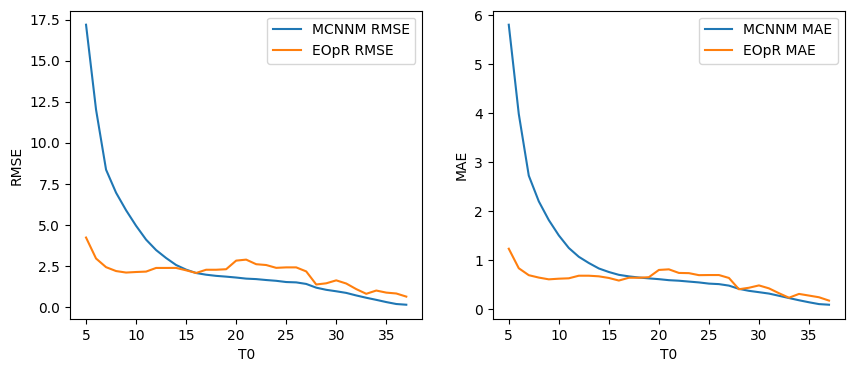

In [10]:
plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(mcnnm_rmses), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='MCNNM RMSE',
)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(eopr_rmses), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='EOpR RMSE',
)
plt.xlabel('T0')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(mcnnm_maes), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='MCNNM MAE',
)
plt.plot(
    np.arange(start_time, num_time_steps),
    ei.reduce(
        ei.rearrange(np.asarray(eopr_maes), '(b d) -> b d', b=num_seeds),
        'b d -> d',
        np.mean,
    ),
    label='EOpR MAE',
)
plt.xlabel('T0')
plt.ylabel('MAE')
plt.legend()

plt.show()